# MOHID Preprocessing

- Create regular grids
- Download, load and filter coastlines for grid region
- Perform interpolation on bathymetric data
- Update griddata depth values
- Convert the griddata to a shapefile
- Plot bathymetry

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: Use the Kernel and Cell menus to restart the kernel and clear outputs.<br>
***

# Table of contents
- [1. Import required libraries](#1.-Import-required-librarie)
- [2. Load the XYZ data](#2.-Load-the-XYZ-data)
- [3. Get grid dimensions and spacing](#3.-Get-grid-dimensions-and-spacing)
- [4. Grid generation](#4.-Grid-generation)
- [5. Save the grid to a MOHID-compatible file](#5.-Save-the-grid-to-a-MOHID-compatible-file)
- [6. Download GSHHG Coastline Data](#6.-Download-GSHHG-Coastline-Data)
- [7. Load and Filter Coastlines for Grid Region](#7.-Load-and-Filter-Coastlines-for-Grid-Region)
- [8. Interpolate bathymetric data](#8.-Interpolate-bathymetric-data)
- [9. Load a previously generated Mohid griddata file](#9.-Load-a-previously-generated-Mohid-griddata-file)
- [10. Visualize and update depth values by clicking on the map](#10.-Visualize-and-update-depth-values-by-clicking-on-the-map)
- [11. Save the griddata to a MOHID-compatible file](#11.-Save-the-griddata-to-a-MOHID-compatible-file)
- [12. Convert the griddata to a shapefile](#12.-Convert-the-griddata-to-a-shapefile)
- [13. Plot interpolated bathymetry](#13.-Plot-interpolated-bathymetry)


# 1. Import required libraries

In [4]:
import numpy as np
import pandas as pd
from IPython.display import display
from ipyleaflet import Map, Marker, basemaps, Popup, Polyline, Circle, GeoData, Polygon
from ipywidgets import HTML
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex
import random
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from urllib.request import urlopen, Request
import io
from PIL import Image
import geopandas as gpd
from shapely.geometry import Point, box
import requests
import zipfile
import os
from scipy.ndimage import label, find_objects, gaussian_filter
import matplotlib.colors as mcolors
import ipywidgets as widgets
import shapefile

# 2. Load the XYZ data
This step is optional (only perform if you already have an xyz file with bathymetry data).

In [5]:
file_path = 'data.xyz'  # Replace with your file path
data = pd.read_csv(file_path, header=None, names=['longitude', 'latitude', 'depth'], sep='\\s+')
# Convert to list of dictionaries
data_list = data.to_dict(orient='records')

# Define the maximum number of points to display
MAX_POINTS = 1000  # Adjust based on performance needs

# If the dataset is too large, randomly sample points
if len(data_list) > MAX_POINTS:
    data_sample = random.sample(data_list, MAX_POINTS)

# Calculate the mean latitude and longitude for centering the map
center_lat = np.mean([row['latitude'] for row in data_sample])
center_lon = np.mean([row['longitude'] for row in data_sample])
grid_map = Map(center=(center_lat, center_lon), zoom=10)

# Define colormap and normalization
cmap = cm.viridis  # Choose a colormap like 'viridis', 'plasma', etc.
norm = Normalize(vmin=min(row['depth'] for row in data_sample), vmax=max(row['depth'] for row in data_sample))

# Function to convert a value into a color
def value_to_color(value):
    return to_hex(cmap(norm(value)))  # Convert RGBA to hex

# Add circles to the map
for row in data_sample:
    marker = Circle(
        location=(row['latitude'], row['longitude']),
        radius=30,
        color=value_to_color(row['depth']),
        fill_color=value_to_color(row['depth']),
        fill_opacity=0.7
    )
    grid_map.add_layer(marker)

# 3. Get grid dimensions and spacing

In [6]:
nx = int(input("Enter the number of cells in the x-direction (nx): "))
ny = int(input("Enter the number of cells in the y-direction (ny): "))

Enter the number of cells in the x-direction (nx): 100
Enter the number of cells in the y-direction (ny): 100


In [7]:
dx = float(input("Enter the cell size in the x-direction (dx, in degrees): "))
dy = float(input("Enter the cell size in the y-direction (dy, in degrees): "))

Enter the cell size in the x-direction (dx, in degrees): 0.01
Enter the cell size in the y-direction (dy, in degrees): 0.01


# 4. Grid generation
Click on the map to create the grid

In [8]:
# Initialize the interactive map
try:
    grid_map
except NameError:
    grid_map = Map(center=(0.0, 0.0), zoom=2)


# Display the map
display(grid_map)


# Store polylines so they can be removed later
polylines = []
marker = []

# Display instructions
instructions = HTML(
    """
    <h4>Interactive Map for Grid Generation</h4>
    <ol>
        <li>Click anywhere on the map to find the origin coordinates (latitude and longitude).</li>
        <li>The grid will be visualized as a mesh directly on the map.</li>
    </ol>
    """
)
display(instructions)

# Function to handle clicks on the map
def handle_map_click(**kwargs):
    global marker, x0, y0
    
    if kwargs.get("type") == "click":  # Ensure this is a click event
        y0 = kwargs["coordinates"][0]
        x0 = kwargs["coordinates"][1]

        if marker in grid_map.layers:
            grid_map.remove_layer(marker)
            
        # Add a marker to the map at the clicked location
        marker = Marker(location=(y0, x0))
        grid_map.add_layer(marker)

        generate_grid(x0,y0)

def generate_grid(x0,y0):
    global polylines  # Access the global variable to update it
    global x_grid, y_grid 
        
    x_coords = np.linspace(x0, x0 + dx * (nx - 1), nx)
    y_coords = np.linspace(y0, y0 + dy * (ny - 1), ny)

    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

     # Remove existing polylines from the map if they exist
    for polyline in polylines:
        if polyline in grid_map.layers:
            grid_map.remove_layer(polyline)
    polylines = []  # Clear the list after removing polylines

    # Collect all horizontal and vertical grid lines in one go
    all_grid_lines = []

    for j in range(ny):
        points = [(y_grid[j, i], x_grid[j, i]) for i in range(nx)]
        all_grid_lines.append(points)

    for i in range(nx):
        points = [(y_grid[j, i], x_grid[j, i]) for j in range(ny)]
        all_grid_lines.append(points)

    # Create a single Polyline layer for all grid lines
    polyline = Polyline(
        locations=all_grid_lines, 
        color="blue", 
        weight=1
    )
    
    # Add the grid lines to the map in one shot
    grid_map.add_layer(polyline)
    polylines.append(polyline)  # Keep track of this polyline
    
    #print("\nGrid generation complete!")
    #print(f"Grid dimensions: {nx} x {ny}")
    #print(f"x-coordinates range: {x_coords[0]} to {x_coords[-1]}")
    #print(f"y-coordinates range: {y_coords[0]} to {y_coords[-1]}")
    
# Attach the click handler to the map
grid_map.on_interaction(handle_map_click)


Map(center=[-1.1702571135000002, -48.61046824], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zo…

HTML(value='\n    <h4>Interactive Map for Grid Generation</h4>\n    <ol>\n        <li>Click anywhere on the ma…

# 5. Save the grid to a MOHID-compatible file

In [24]:
# Get current date and time
now = datetime.now()

# Format the date and time
formatted_date_time = now.strftime("%d-%m-%Y %H:%M:%S")

output_file = "mohid_grid.grd"
with open(output_file, "w") as f:
    f.write("PROJ4_STRING              : +proj=longlat +datum=WGS84 +no_defs\n")
    f.write("COMENT1                   : Grid generated by MOHID Jupyter Notebook\n")
    f.write("COMENT1                   : Generation Time: " + formatted_date_time + "\n")
    f.write("LATITUDE                  : " + str(y0) + "\n")
    f.write("LONGITUDE                 : " + str(x0) + "\n")
    f.write("COORD_TIP                 : 4\n")
    f.write("ILB_IUB                   : 1 " + str(ny) + "\n")
    f.write("JLB_JUB                   : 1 " + str(nx) + "\n")
    f.write("ORIGIN                    : " + str(x0) + " " + str(y0) + "\n")
    f.write("GRID_ANGLE                : 0\n")
    f.write("CONSTANT_SPACING_X        : 1\n")
    f.write("CONSTANT_SPACING_Y        : 1\n")
    f.write("DX                        : " + str(dx) + "\n")
    f.write("DY                        : " + str(dy) + "\n")

print(f"\nGrid saved to {output_file}")


Grid saved to mohid_grid.grd


# 6. Download GSHHG Coastline Data

In [10]:
# Define URL and local paths
gshhg_url = "https://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip"
zip_path = "gshhg_shapefiles.zip"
extract_path = "gshhg_data"

# Download the file if not exists
if not os.path.exists(zip_path):
    print("Downloading GSHHG data...")
    response = requests.get(gshhg_url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

# Extract the files
if not os.path.exists(extract_path):
    print("Extracting GSHHG data...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

print("GSHHG data is ready.")

GSHHG data is ready.


# 7. Load and Filter Coastlines for Grid Region

In [11]:
# Load the coastline shapefile
#coastline_shapefile = os.path.join(extract_path, "GSHHS_shp", "f", "GSHHS_f_L1.shp") #if using downloaded GSHHG coastline data
coastline_shapefile = "Coastlines/Para_3_completo.shp" #if using other coastline data

coastlines = gpd.read_file(coastline_shapefile)

# Define a bounding box
np_x = np.array(x_grid)
np_y = np.array(y_grid)

c = 3
x_min=np.min(np_x)-dx*c; y_min=np.min(np_y)-dy*c; x_max=np.max(np_x)+dx*c; y_max=np.max(np_y)+dy*c

bbox = [x_min, y_min, x_max, y_max] #[min_lon, min_lat, max_lon, max_lat]

# Create a bounding box geometry
bbox_geom = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=coastlines.crs)

# Filter coastlines for the bounding box
filtered_coastlines = gpd.overlay(coastlines, bbox_geom, how='intersection')

# Convert to GeoJSON
coastline_geojson = filtered_coastlines.to_json()


# Convert to GeoJSON for ipyleaflet
#coastline_geojson = filtered_coastlines.__geo_interface__

# Create an interactive map centered in the region
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2
m = Map(center=(center_lat, center_lon), zoom=8)

# Add coastlines
geo_layer = GeoData(geo_dataframe=filtered_coastlines, style={"color": "blue", "weight": 1})

# Add to map
m.add_layer(geo_layer)

# Display the map
m

Map(center=[-1.234028, -48.575320000000005], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

# 8. Interpolate bathymetric data

In [12]:
# Retrieves longitude, latitude, and depth values from the dataset
lons = data['longitude'].values
lats = data['latitude'].values
depths = data['depth'].values

# Masks and removes NaN values from the data.
mask = ~np.isnan(lons) & ~np.isnan(lats) & ~np.isnan(depths)
lons, lats, depths = lons[mask], lats[mask], depths[mask]

# Initialized a griddata matrix with all values set to -99
zi = np.full_like(x_grid, -99, dtype=float)  

# Convert coastline geometries to Shapely Polygons
polygons = list(filtered_coastlines.geometry)

# Function to check if a point is inside any coastline polygon
def is_inside_polygons(x, y, polygons):
    point = Point(x, y)
    return any(poly.contains(point) for poly in polygons)

# Create a mask to determine points outside polygons
water_mask = np.array([
    not is_inside_polygons(x, y, polygons)
    for x, y in zip(x_grid.flatten(), y_grid.flatten())
]).reshape(x_grid.shape)


# Perform interpolation with method='nearest' to allow extrapolation
method = "nearest" #cubic linear nearest

# Interpolate only outside coastline polygons
zi[water_mask] = griddata((lons, lats), depths, (x_grid[water_mask], y_grid[water_mask]), method=method)

# Define a minimum depth
min_depth = 0

# Change all values in 'zi' below the min_depth
zi[(zi < min_depth)] = min_depth
      
# Apply Gaussian filter to smooth 'zi'
sigma = 1  # Standard deviation for Gaussian kernel

# Smooth the valid data points using Gaussian filter
zi = gaussian_filter(zi * water_mask, sigma)

# Define -99 in land cells
zi[~water_mask] = -99

# Labels connected components to identify isolated cells
labeled_array, num_features = label(water_mask)

#Set the minimum number of connected cells required
isolated_cells_number = 20

# Marks isolated cells as -99 if they are fewer than the specified threshold
for label_idx in range(1, num_features + 1):
    component_mask = labeled_array == label_idx
    if np.sum(component_mask) < isolated_cells_number:
        zi[component_mask] = -99 

# 9. Load a previously generated Mohid griddata file

In [ ]:
# Load grid data from file
file_path = "mohid_griddata.dat"

# Load a MOHID grid data file
with open(file_path, 'r') as f:
    lines = f.readlines()

grid_data = []
n_rows, n_cols = None, None  # Use None to detect missing values
start_reading = False

for line in lines:
    parts = line.split()

    if line.startswith("ILB_IUB"):
        n_rows = int(parts[3]) 
    elif line.startswith("JLB_JUB"):
        n_cols = int(parts[3])
    elif line.startswith("ORIGIN"):
        x0 = float(parts[2])
        y0 = float(parts[3])
    elif line.startswith("DX"):
        dx = float(parts[2])
    elif line.startswith("DY"):
        dy = float(parts[2])
    elif "<BeginGridData2D>" in line:
        start_reading = True
        continue
    elif "<EndGridData2D>" in line:
        break
    elif start_reading:
        try:
            grid_data.append(float(line.strip()))
        except ValueError:
            print(f"Warning: Skipping invalid line -> {line.strip()}")

# Debugging prints
print(f"Extracted Dimensions: n_rows={n_rows}, n_cols={n_cols}")
print(f"Grid Data Length: {len(grid_data)}")

# Ensure grid dimensions are valid
if n_rows is None or n_cols is None:
    raise ValueError("Grid dimensions could not be determined from the file.")

# Check if data size matches expected shape
expected_size = n_rows * n_cols
if len(grid_data) != expected_size:
    raise ValueError(f"Mismatch: Grid data size {len(grid_data)} does not match expected ({expected_size}).")

# Convert to NumPy array and reshape correctly
zi = np.array(grid_data).reshape(n_rows, n_cols)

x_coords = np.linspace(x0, x0 + dx * (n_cols - 1), n_cols)
y_coords = np.linspace(y0, y0 + dy * (n_rows - 1), n_rows)

x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    
print(f"Loaded grid data shape: {zi.shape}")

# 10. Visualize and update depth values by clicking on the map

In [13]:
# Grid setup
n_rows, n_cols = zi.shape
np_x = np.array(x_grid)
np_y = np.array(y_grid)

min_lon, max_lon = np.min(np_x), np.max(np_x)
min_lat, max_lat = np.min(np_y), np.max(np_y)

# Create the map
m = Map(center=(np.mean(np_y), (np.mean(np_x))), zoom=8)

marker = []

# Function to get grid index
def get_grid_index(lon, lat):
    """Convert lat/lon to grid indices and ensure they are within bounds."""
    j = int((lon - min_lon) / (max_lon - min_lon) * (n_cols - 1))
    i = int((lat - min_lat) / (max_lat - min_lat) * (n_rows - 1))

    if 0 <= j < n_cols and 0 <= i < n_rows:
        return j, i
    return None, None

# Function to update depth values
def update_depth(**kwargs):
    global marker
    
    """Triggered when a user clicks on the map."""
    if kwargs.get("type") == "click":  # Ensure this is a click event
        clicked_lat = kwargs["coordinates"][0]
        clicked_lon = kwargs["coordinates"][1]

        if marker in m.layers:
            m.remove_layer(marker)
            
        # Add a marker to the map at the clicked location
        marker = Marker(location=(clicked_lat, clicked_lon))
        m.add_layer(marker)

        
        j, i = get_grid_index(clicked_lon, clicked_lat)
        if j is None or i is None:
            print("Click outside grid bounds.")
            return

        # Display a textbox widget for the user to input the new depth
        input_box = widgets.Text(
            value='',
            placeholder='Enter new depth value...',
            description=(f'Cell ({i}, {j}) with depth {zi[i][j]:.1f}:'),
            disabled=False,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px'),
        )
        
        # Create a button for submission
        submit_button = widgets.Button(description="Submit")
        
        # Function to handle the input when the user presses the submit button
        def on_submit(change):
            try:
                new_depth_value = float(input_box.value)
                zi[i, j] = new_depth_value
                update_cell(i, j)  # Update only the modified cell
                display(f"Depth value for cell ({i}, {j}) updated to {new_depth_value}")
            except ValueError:
                display("Invalid input. Please enter a numeric value.")

        submit_button.on_click(on_submit)

        # Display the input box and submit button
        display(input_box, submit_button)

# Function to update a single grid cell
def update_cell(i, j):
    """Update only the modified grid cell on the map."""
    norm = Normalize(vmin=zi[zi != -99].min(), vmax=zi.max())
    rgb = plt.cm.viridis(norm(zi[i, j]))[:3]  # Extract RGB tuple
    color = mcolors.to_hex(rgb)  # Convert to hex format

    lon_left = min_lon + (max_lon - min_lon) * j / (n_cols - 1)
    lon_right = min_lon + (max_lon - min_lon) * (j + 1) / (n_cols - 1)
    lat_bottom = min_lat + (max_lat - min_lat) * i / (n_rows - 1)
    lat_top = min_lat + (max_lat - min_lat) * (i + 1) / (n_rows - 1)

    polygon = Polygon(
        locations=[(lat_bottom, lon_left), (lat_bottom, lon_right),
                   (lat_top, lon_right), (lat_top, lon_left)],
        color=color,
        fill_opacity=0.6
    )
    m.add_layer(polygon)

# Function to initialize the map with all grid cells
def update_map():
    """Draw all grid cells initially."""
    m.layers = [m.layers[0]]  # Keep only the base map

    norm = Normalize(vmin=zi[zi != -99].min(), vmax=zi.max())

    for i in range(n_rows):
        for j in range(n_cols):
            if zi[i, j] != -99:
                update_cell(i, j)

# Display the map and initial grid
update_map()
display(m)

# Add click event listener
m.on_interaction(update_depth)

Map(center=[-1.234028, -48.57532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Text(value='', description='Cell (21, 55) with depth -99.0:', layout=Layout(width='400px'), placeholder='Enter…

Button(description='Submit', style=ButtonStyle())

'Depth value for cell (21, 55) updated to 5.0'

# 11. Save the griddata to a MOHID-compatible file

In [14]:
# Get current date and time
now = datetime.now()

# Format the date and time
formatted_date_time = now.strftime("%d-%m-%Y %H:%M:%S")

output_file = "mohid_griddata.dat"
with open(output_file, "w") as f:
    f.write("PROJ4_STRING              : +proj=longlat +datum=WGS84 +no_defs\n")
    f.write("COMENT1                   : Grid generated by MOHID Jupyter Notebook\n")
    f.write("COMENT1                   : Generation Time: " + formatted_date_time + "\n")
    f.write("LATITUDE                  : " + str(y0) + "\n")
    f.write("LONGITUDE                 : " + str(x0) + "\n")
    f.write("COORD_TIP                 : 4\n")
    f.write("ILB_IUB                   : 1 " + str(ny) + "\n")
    f.write("JLB_JUB                   : 1 " + str(nx) + "\n")
    f.write("ORIGIN                    : " + str(x0) + " " + str(y0) + "\n")
    f.write("GRID_ANGLE                : 0\n")
    f.write("CONSTANT_SPACING_X        : 1\n")
    f.write("CONSTANT_SPACING_Y        : 1\n")
    f.write("DX                        : " + str(dx) + "\n")
    f.write("DY                        : " + str(dy) + "\n")
    f.write("FILL_VALUE                : -99\n")
    f.write("<BeginGridData2D>\n")
    
    for i in range(n_rows):
        for j in range(n_cols):
            f.write(f"{zi[i][j]:.1f}\n")
            
    f.write("<EndGridData2D>")       
    

print(f"\nGrid saved to {output_file}")


Grid saved to mohid_griddata.dat


# 12. Convert the griddata to a shapefile

In [15]:
# Create a shapefile writer object
w = shapefile.Writer('depth_grid_cells', shapefile.POLYGON)
w.field('i', 'N')       # Row index (i)
w.field('j', 'N')       # Column index (j)
w.field('Depth', 'F', decimal=2)  # Depth value (float)

# Loop through the grid and create polygon cells
for i in range(len(zi) - 1):  # -1 to avoid index out of bounds
    for j in range(len(zi[i]) - 1):
        depth = zi[i, j]  # Get depth value
        
        # 🔹 Exclude land cells (-99 depth)
        if depth == -99:
            continue

        # Define the 4 corner points of the grid cell
        lon1, lat1 = x_grid[i, j], y_grid[i, j]   # Bottom-left
        lon2, lat2 = x_grid[i, j+1], y_grid[i, j+1]  # Bottom-right
        lon3, lat3 = x_grid[i+1, j+1], y_grid[i+1, j+1]  # Top-right
        lon4, lat4 = x_grid[i+1, j], y_grid[i+1, j]  # Top-left
        
        # Create a polygon for the grid cell
        w.poly([[ (lon1, lat1), (lon2, lat2), (lon3, lat3), (lon4, lat4), (lon1, lat1) ]])  
        
        # Add attributes (Row, Col, Depth)
        w.record(i+1, j+1, depth)

# Save the shapefile
w.close()

print("Shapefile 'depth_grid_cells.shp' created successfully (excluding -99 depths).")


Shapefile 'depth_grid_cells.shp' created successfully (excluding -99 depths).


# 13. Plot interpolated bathymetry

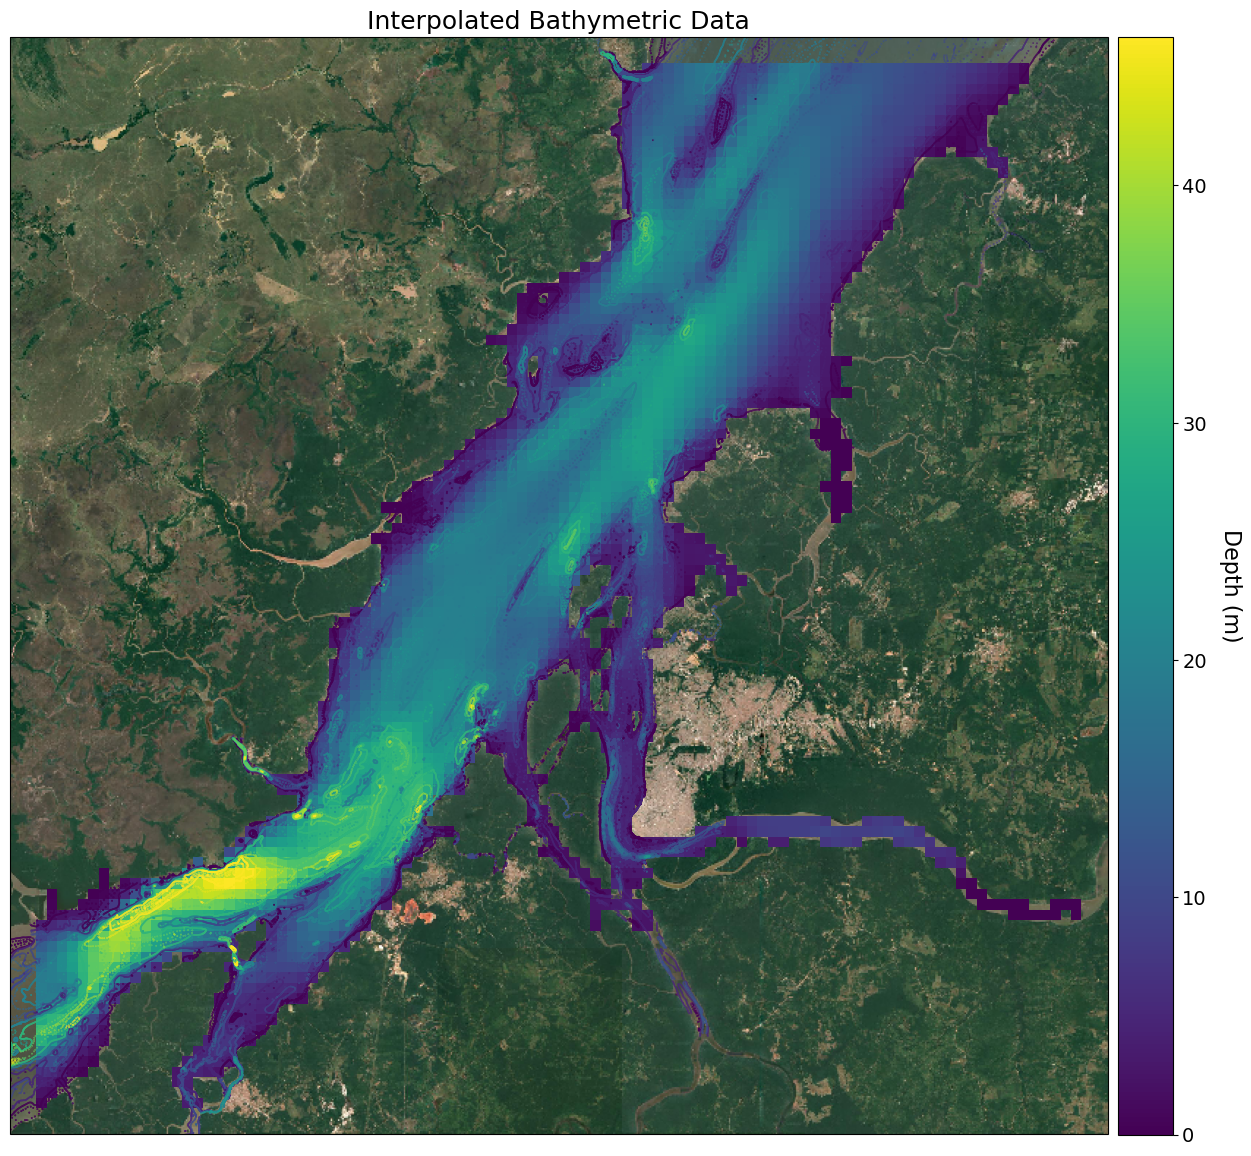

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

np_x = np.array(x_grid)
np_y = np.array(y_grid)

c = 3
x_min = np.min(np_x) - dx * c
y_min = np.min(np_y) - dy * c
x_max = np.max(np_x) + dx * c
y_max = np.max(np_y) + dy * c

extent = [x_max, x_min, y_max, y_min]

# Set the image size and create the figure
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

def image_spoof(self, tile):
    url = self._image_url(tile)  # Get the URL of the street map API
    req = Request(url)  # Start request
    req.add_header('User-agent', 'Anaconda 3')  # Add user agent to request
    fh = urlopen(req)
    im_data = io.BytesIO(fh.read())  # Get image
    fh.close()  # Close URL
    img = Image.open(im_data)  # Open image with PIL
    img = img.convert(self.desired_tile_form)  # Set image format
    return img, self.tileextent(tile), 'lower'  # Reformat for cartopy

cimgt.GoogleTiles.get_image = image_spoof  # Reformat web request for street map spoofing
osm_img = cimgt.GoogleTiles(style='satellite')
ax.add_image(osm_img, int(12))

zi_mask = np.ma.masked_array(zi, zi <= -99)  # Mask to set transparency to a certain value

# Normalizing the data for the colorbar
norm = Normalize(vmin=np.min(zi_mask), vmax=np.max(zi_mask))

# Plot pcolormesh
pc = ax.pcolormesh(x_grid, y_grid, zi_mask, cmap='viridis', norm=norm)

# Plot scatter
scatter = ax.scatter(lons, lats, c=depths, s=0.1, cmap='viridis', norm=norm, label='Data Points')

#Title
plt.title('Interpolated Bathymetric Data', fontsize=18, loc='center')

# Adjust the size of the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

cbar = plt.colorbar(pc, cax=cax, orientation="vertical")
cbar.set_label('Depth (m)', labelpad=25, rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.savefig(rf'Griddata.png', format='png', dpi=300, bbox_inches='tight')